In [1]:
# %matplotlib notebook

from matplotlib import pylab
from astropy.coordinates import SkyCoord
import integralclient as ic

import time
import numpy as np

from astropy.table import Table, vstack
from astropy.io import fits
import glob
from scipy import stats
from astropy.time import Time

failed to get AUTH with env due to: 'K8S_SECRET_INTEGRAL_CLIENT_SECRET'
got AUTH with homefile for integral-limited


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
RA=293.732
Dec=21.8967222
tstart_rel_mseconds=300.0
tstop_rel_seconds=300.0
t0_utc="2023-05-18T12:59:08.000000" 
# t0_utc=Time(Time("2022-10-14T19:21:47").mjd - 8.632259375000002/24/3600, format='mjd').isot.replace(" ", "T") # hard x-ray
# t0_utc="2022-10-14T19:21:47"
# rt=1
nrt=1
arc=0
required_completeness=0.6
mode="scw" # scw|rt|arc
global_snr_threshold=3.
negative_excesses=0

In [3]:
t0_utc

'2023-05-18T12:59:08.000000'

In [4]:
if mode == "scw":
    rt=0
    nrt=1
    arc=0
elif mode == "rt":
    rt=1
    nrt=0
    arc=0
elif mode == "arc":
    rt=0
    nrt=0
    arc=1
elif mode == "flags":
    print("mode set by flags")
else:
    raise Exception("unknown mode: {}, allowed: scw, rt".format(mode))

In [5]:
source_coord = SkyCoord(RA, Dec, unit = "deg")

In [6]:
import importlib

In [7]:
# /home/savchenk/work/transients/workflows/integral-all-sky

import integralenv
importlib.reload(integralenv)

arc_root_prefix = integralenv.get_arc_root_prefix()

In [8]:
now_ijd = float(ic.converttime("UTC",time.strftime("%Y-%m-%dT%H:%M:%S"),"IJD"))
t0_ijd =  float(ic.converttime("UTC",t0_utc,"IJD"))

tstart_ijd = t0_ijd - tstart_rel_mseconds/24./3600
tstop_ijd = t0_ijd + tstop_rel_seconds/24./3600

now_ijd, t0_ijd, tstart_ijd, tstop_ijd

2023-05-18 18:21:34 savchenk-NG-VN7-793G-79EG root[707599] INFO url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw//timesystem/api/v1.0/converttime/UTC/2023-05-18T18:21:34/IJD
2023-05-18 18:21:48 savchenk-NG-VN7-793G-79EG root[707599] INFO url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw//timesystem/api/v1.0/converttime/UTC/2023-05-18T12:59:08.000000/IJD


(8538.765777592593, 8538.541865555555, 8538.538393333332, 8538.545337777778)

In [9]:
lcs={}


In [10]:
if nrt == 1:
    import isdcclient

    IC = isdcclient.ISDCClient()

    
    lcs['ACS'] = IC.genlc("ACS", t0_utc, "%.10lg"%max(tstart_rel_mseconds,tstop_rel_seconds),format='numpy')
    lcs['ACS'][:,1] = 0.05
    print("got ACS", lcs['ACS'])
    
    #lcs['IBIS/Veto'] = IC.genlc("IBIS_VETO", t0_utc, "%.10lg"%max(tstart_rel_mseconds,tstop_rel_seconds),format='numpy')
    #lcs['IBIS/Veto'][:,1] = 8.

https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/integralhk/api/v1.0/genlc/ACS/2023-05-18T12:59:08.000000/300
got ACS [[8.53853839e+03 5.00000000e-02 4.30000000e+03 4.64480124e+04]
 [8.53853839e+03 5.00000000e-02 4.42600000e+03 4.64480624e+04]
 [8.53853839e+03 5.00000000e-02 4.40000000e+03 4.64481124e+04]
 ...
 [8.53854534e+03 5.00000000e-02 4.31400000e+03 4.70478627e+04]
 [8.53854534e+03 5.00000000e-02 4.39800000e+03 4.70479127e+04]
 [8.53854534e+03 5.00000000e-02 4.42000000e+03 4.70479627e+04]]


(-2.0, 2.0)

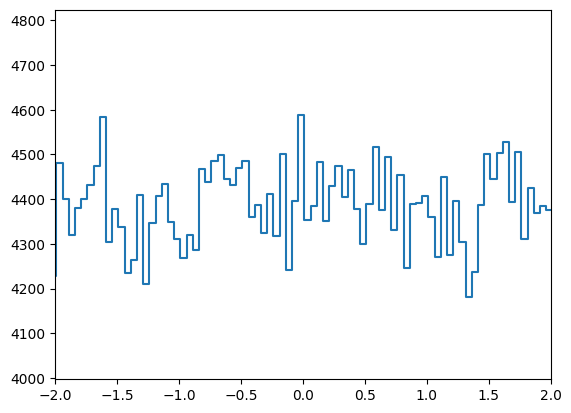

In [11]:
from matplotlib import pylab as plt

plt.figure()

plt.step(
    (lcs['ACS'][:,0] - t0_ijd)*24*3600,
    lcs['ACS'][:,2],
)

plt.xlim(-2,2)

In [12]:
def rebin(lc,n,av = False):
    if n == 0: return lc
    
    N=int(lc.shape[0]/n)*n
    if av:
        return lc[:N].reshape((int(lc.shape[0]/n), n)).mean(1)
    else:
        return lc[:N].reshape((int(lc.shape[0]/n), n)).sum(1)

In [13]:
import re
import time

# if rt == 1:

#     got_data = False
    
#     while not got_data:
#         current_rev=float(ic.converttime("UTC",t0_utc,"REVNUM"))

#         print("current rev", current_rev)

#         rtdata_roots=[
#             '/unsaved/astro/savchenk/dockers/realtimeacs/docker-ibas/spiacs-lcdump',
#             '/rtdata',
#             '/mnt/sshfs/isdc-in01//unsaved/astro/savchenk/dockers/realtimeacs/docker-ibas/spiacs-lcdump',    
#         ]

#         for realtime_dump_root in rtdata_roots + [ None ]:
#             #print("probing",realtime_dump_root,"with",glob.glob(realtime_dump_root+"/lcdump-revol-*.csv"))
#             if realtime_dump_root and len(glob.glob(realtime_dump_root+"/lcdump-revol-*.csv"))>0:
#                 print("this",realtime_dump_root)
#                 break

#         if not realtime_dump_root:
#             raise Exception("no realtime archvie found")

#         for rt_fn in reversed(sorted([l for l in glob.glob(realtime_dump_root+"/lcdump-revol-*.csv") if 
#                        float(re.search("lcdump-revol-(\d{4}).*.csv",l).groups()[0])<=current_rev+1])):

#             print(rt_fn)

#             rt_lc = np.genfromtxt(rt_fn)

#             lcs['ACS']=rt_lc[:,(3,0,2,0)]
#             lcs['ACS'][:,1] = 0.05

#             first_data = lcs['ACS'][:,0][0]
#             last_data = lcs['ACS'][:,0][-1]

#             print("now", now_ijd, 
#                   "first data in file", first_data, 
#                   "last data", last_data, 
#                   "requested", t0_ijd, 
#                   "have margin", (last_data-t0_ijd)*24*3600,"s",
#                   "data delay", (now_ijd-last_data)*24*3600,"s")       


#             if t0_ijd<first_data:
#                 print("data in the previous file")
#                 continue
                

#             print("margin",(last_data-now_ijd)*24*3600-tstop_rel_seconds*1.5 + 100)
#             if  (last_data-t0_ijd)*24*3600>tstop_rel_seconds*1.5 + 100:                            
#                 print("this margin is sufficient")
#                 got_data=True
#                 break
#             else:
#                 print("this margin is NOT sufficient, waiting")
#             #    if (now_ijd-last_data)*24*3600>1000:
#             #        raise RuntimeError('margin insufficent, data too old: no more hope')                

#                 time.sleep(30)
#                 break
        
            
            

    

In [14]:
import requests


if rt == 1:
    r = requests.get(f"https://www.astro.unige.ch/mmoda/dispatch-data/gw/integralhk/api/v1.0/rtlc/{t0_utc}/{tstop_rel_seconds}?json")
    lc = np.array(r.json()['data'])
    lcs['ACS'] = np.vstack([lc[:,1], lc[:,1] * 0 + 0.05, lc[:,0]]).T

In [15]:
# lcs['ACS']

lcs['ACS'][:,0].min()

8538.538393476889

total lc (12000, 4)
min -0.003472078666163725
max 0.003471790929324925
expected telapse 600.0 telapse 599.9503330502193 ontime 600.0000000000001
size (12000, 4) (12000,)
requested scale 0.05
b_tb 0.05000000000000001
acceptable, will be 1 0.05000000000000001
rebinned to (12000,)
{'meanrate': 87609.66666666664, 'maxrate': 95719.99999999999, 'stdvar': 1560.1427142697198, 'meanerr': 1323.7043980184294, 'excvar': 1.1786186678878123, 'maxsnr': 4.973350250442357, 'localfar': 0.00394833663792898, 'localfar_s': 2.882260100784239}
requested scale 0.5
b_tb 0.05000000000000001
acceptable, will be 9 0.45000000000000007
rebinned to (1333,)
{'meanrate': 87609.68242060514, 'maxrate': 89293.33333333331, 'stdvar': 541.1486646296396, 'meanerr': 441.2348390108155, 'excvar': 1.2264413794767801, 'maxsnr': 3.081782568066246, 'localfar': 1.3714242449523728, 'localfar_s': 0}
requested scale 1
b_tb 0.05000000000000001
acceptable, will be 19 0.9500000000000002
rebinned to (631,)
{'meanrate': 87609.43531570605, '

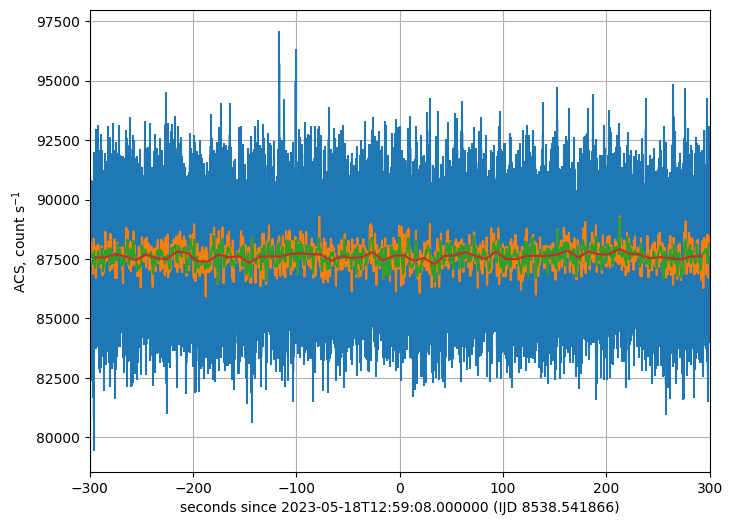

In [16]:
summary = dict()    

for n, lc in lcs.items():

    try:
        rel_s = (lc[:,0]-t0_ijd)*24*3600
    except:
        continue

    m = rel_s>-tstart_rel_mseconds
    m &= rel_s<tstop_rel_seconds

    print("total lc",lc.shape)
    print("min",lc[:,0].min()-t0_ijd)
    print("max",lc[:,0].max()-t0_ijd)

    lc = lc[m]

    b_tb = np.mean(lc[:,1])    

    rel_s = (lc[:,0]-t0_ijd)*24*3600

    expected_telapse = tstop_rel_seconds + tstop_rel_seconds    

    if len(rel_s) == 0:
        telapse = 0
        ontime = 0
    else:
        telapse = rel_s.max() - rel_s.min()
        ontime = np.sum(lc[:,1])


    print("expected telapse", expected_telapse, "telapse", telapse, "ontime", ontime)

    if float(ontime) / expected_telapse < required_completeness:
        raise Exception("data not available: exected %.5lg elapsed %.5lg ontime %.5lg completeness %s requireed %s"%(
            expected_telapse, telapse, ontime,
            ontime / expected_telapse, required_completeness))

    lc_summary = dict()
    summary[n.replace("/","_")]=lc_summary

    print("size", lc.shape, rel_s.shape)

    if np.sum(m) == 0: continue

    pylab.figure(figsize=(8,6))


    for ascale in [0.05, 0.5, 1, 10]:
        summary_scale = dict()
        lc_summary[('s_%.5lg'%ascale).replace(".","_")] = summary_scale        


        print("requested scale",ascale)
        print("b_tb",b_tb)

        if b_tb>ascale:
            ascale = b_tb


        nscale = int(ascale/b_tb)
        scale=nscale*b_tb

        print("acceptable, will be", nscale, scale)

        rate = rebin(lc[:,2],nscale,False)/scale
        rate_err = rebin(lc[:,2],nscale,False)**0.5/scale

        print("rebinned to",rate.shape)

        pylab.errorbar(
            rebin(rel_s,nscale,True),
            rate,
            rate_err,
            xerr=scale/4.
        )

        summary_scale['meanrate'] = np.mean(rate)
        summary_scale['maxrate'] = np.max(rate)
        summary_scale['stdvar'] = np.std(rate)
        summary_scale['meanerr'] = np.mean(rate_err**2)**0.5
        summary_scale['excvar'] = summary_scale['stdvar']/summary_scale['meanerr']        

        summary_scale['maxsnr'] = np.max((rate-np.mean(rate))/rate_err/summary_scale['excvar'])

        summary_scale['localfar'] = stats.norm.sf(summary_scale['maxsnr'])*rate.shape[0]

        summary_scale['localfar_s'] = stats.norm.isf(summary_scale['localfar']/2.) if summary_scale['localfar']<1 else 0

        # add FAR spike here

        if 'best' not in lc_summary or summary_scale['localfar_s'] > lc_summary['best']['localfar_s']:
            lc_summary['best'] = dict(
                localfar_s = summary_scale['localfar_s'],
                scale = ascale,
            )

        print(summary_scale)


    #tight_layout()
    pylab.grid()

    pylab.xlim(-tstart_rel_mseconds, tstop_rel_seconds)
    #pylab.axhspan(0,10,alpha=0.2,color="red")
    #pylab.axhspan(10,15,alpha=0.2,color="green")
    #pylab.axhspan(15,20,alpha=0.2,color="blue")
    pylab.ylabel(n+", count s$^{-1}$")
    #ylim([0,50])
    pylab.xlabel("seconds since %s (IJD %.10lg)"%(t0_utc, t0_ijd))

    fn=n.replace("/","_") + "_lc.png"
    pylab.savefig(fn)
    print("saving as",fn)
    break


In [17]:
# below S/N of 4 FAR is determined primarily by poisson, above - by spikes

def approx_FAR_spike_hz(snr, scale):    
    lim_snr = 2
    
    spike_rate_snr6 = 60./3600./24.
    if scale>=0.1:
        spike_rate_snr6*=(scale/0.1)**-1
    
    
    approx_FAR_hz = snr*0 + spike_rate_snr6 * (lim_snr/6.)**-2.7 
    
    try:
        if snr>lim_snr:
            approx_FAR_hz = spike_rate_snr6 * (np.abs(snr)/6.)**-2.7
    except:
        m=snr>lim_snr
        approx_FAR_hz[m] = (np.abs(snr[m])/6.)**-2.7 * spike_rate_snr6
        

    return approx_FAR_hz

def approx_FAR_norm_hz(snr, scale_s):
    return stats.norm.sf(snr)/scale_s

def approx_FAP(snr, t, scale_s):
    
    try:
        t_scaled = t[:]
        t_scaled[abs(t)<scale_s]=scale_s
    except:
        if abs(t)<scale_s:
            t_scaled=scale_s
        else:
            t_scaled=t

    approx_FAP = 2 * ( approx_FAR_norm_hz(snr, scale_s) + approx_FAR_spike_hz(snr, scale_s) )  * abs(t_scaled) * (1+np.log( 30/0.1))
    
    return approx_FAP



(1e-05, 30)

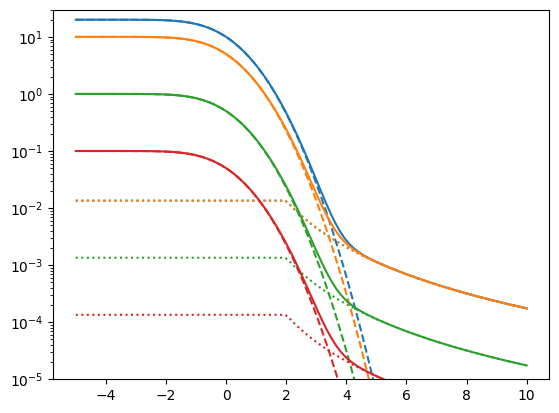

In [18]:
pylab.figure()

x=np.linspace(-5,10,100)

for scale_s in 0.05, 0.1, 1, 10:

    c=pylab.plot(x,approx_FAR_norm_hz(x, scale_s), ls='--')
    pylab.plot(x,approx_FAR_spike_hz(x, scale_s),c=c[0].get_color(),ls=":")
    pylab.plot(x,
               approx_FAR_spike_hz(x, scale_s) + approx_FAR_norm_hz(x, scale_s),
               c=c[0].get_color()
              )


    pylab.semilogy()

pylab.ylim([1e-5, 30])


In [33]:
timescales = sorted(set([0.05*ns for ns in sorted(set(
    list(map(int,np.logspace(0,np.log10(20*30),100))) 
))]  + list(np.linspace(1,31,30*2+1))))
timescales

[0.05,
 0.1,
 0.15000000000000002,
 0.2,
 0.25,
 0.30000000000000004,
 0.35000000000000003,
 0.4,
 0.45,
 0.5,
 0.55,
 0.6000000000000001,
 0.65,
 0.7000000000000001,
 0.75,
 0.8,
 0.8500000000000001,
 0.9,
 0.9500000000000001,
 1.0,
 1.1,
 1.1500000000000001,
 1.25,
 1.3,
 1.4000000000000001,
 1.5,
 1.6,
 1.7000000000000002,
 1.85,
 1.9500000000000002,
 2.0,
 2.1,
 2.25,
 2.4000000000000004,
 2.5,
 2.5500000000000003,
 2.7,
 2.9000000000000004,
 3.0,
 3.1,
 3.3000000000000003,
 3.5,
 3.5500000000000003,
 3.75,
 4.0,
 4.3,
 4.5,
 4.6000000000000005,
 4.9,
 5.0,
 5.2,
 5.5,
 5.550000000000001,
 5.95,
 6.0,
 6.3500000000000005,
 6.5,
 6.75,
 7.0,
 7.2,
 7.5,
 7.7,
 8.0,
 8.200000000000001,
 8.5,
 8.75,
 9.0,
 9.35,
 9.5,
 10.0,
 10.5,
 10.65,
 11.0,
 11.350000000000001,
 11.5,
 12.0,
 12.100000000000001,
 12.5,
 12.950000000000001,
 13.0,
 13.5,
 13.8,
 14.0,
 14.5,
 14.700000000000001,
 15.0,
 15.5,
 15.700000000000001,
 16.0,
 16.5,
 16.75,
 17.0,
 17.5,
 17.85,
 18.0,
 18.5,
 19.0,
 1

total lc (12000, 4)
min -0.003472078666163725
max 0.003471790929324925
expected telapse 600.0 telapse 599.9503330502193 ontime 600.0000000000001
size (12000, 4) (12000,)
requested scale 0.05
true scale 0.05000000000000001
offset 0 rebinned to (12000,)
summary_scale['excvar'] 1.1786186678878123
3666 4.973350250442357 -116.68749777018093
scale 0.05000000000000001 offset 0 found excesses 19
saving as ACS_det_lc.png


{'localfar_s': 2.882260100784239,
 'scale': 0.05000000000000001,
 'summary_scale': {'scale_s': 0.05000000000000001,
  'meanrate': 87609.66666666664,
  'maxrate': 95719.99999999999,
  'stdvar': 1560.1427142697198,
  'meanerr': 1323.7043980184294,
  'excvar': 1.1786186678878123,
  'maxsnr': 4.973350250442357,
  'maxsnr_t': -116.68749777018093,
  'localfar': 0.00394833663792898,
  'localfar_s': 2.882260100784239,
  'excesses': [{'snr': 3.449975514903453,
    'rel_s_scale': -226.63756037363783,
    'rate': 93159.99999999999,
    'rate_err': 1364.9908424601242,
    'rate_overbkg': 5550.333333333343,
    'FAP': 26.43794305757899},
   {'snr': 3.184008394767713,
    'rel_s_scale': -173.08752817916684,
    'rate': 92719.99999999999,
    'rate_err': 1361.7635624439358,
    'rate_overbkg': 5110.333333333343,
    'FAP': 42.62535135761764},
   {'snr': 3.184008394767713,
    'rel_s_scale': -164.48752280557528,
    'rate': 92719.99999999999,
    'rate_err': 1361.7635624439358,
    'rate_overbkg': 511

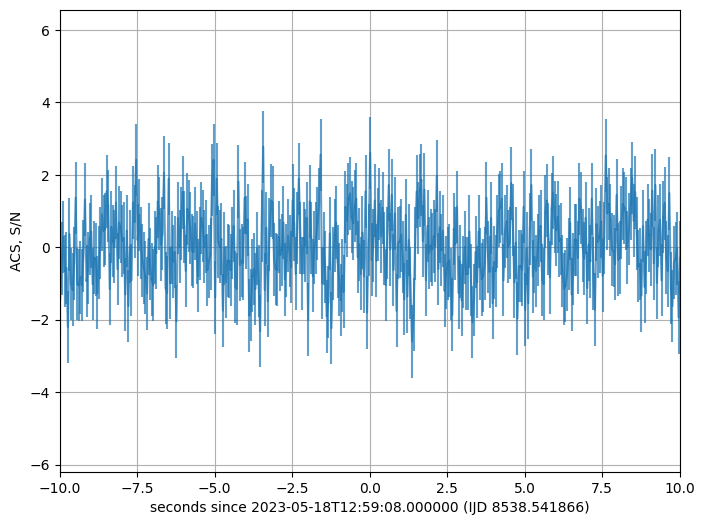

In [51]:
summary = dict()    
all_excesses=[]            

best_lc=None

for n, lc in lcs.items():
    
    #rel_s = lc[:,0]
    rel_s = (lc[:,0]-t0_ijd)*24*3600
    

    m = rel_s>-tstart_rel_mseconds
    m &= rel_s<tstop_rel_seconds
    
    print("total lc",lc.shape)
    print("min",lc[:,0].min()-t0_ijd)
    print("max",lc[:,0].max()-t0_ijd)
    
    lc = lc[m]
   # rel_s = lc[:,0]
    
    b_tb = np.mean(lc[:,1])    
    
    rel_s = (lc[:,0]-t0_ijd)*24*3600
    
    expected_telapse = tstop_rel_seconds + tstop_rel_seconds    
    
    if len(rel_s) == 0:
        telapse = 0
        ontime = 0
    else:
        telapse = rel_s.max() - rel_s.min()
        ontime = np.sum(lc[:,1])
        
    
    print("expected telapse", expected_telapse, "telapse", telapse, "ontime", ontime)
    
    if ontime / expected_telapse < required_completeness:
        raise Exception("data not available: exected %.5lg elapsed %.5lg ontime %.5lg"%(expected_telapse, telapse, ontime))
        
    lc_summary = dict()
    summary[n.replace("/","_")]=lc_summary
    
    print("size", lc.shape, rel_s.shape)
    
    if np.sum(m) == 0: continue
    
    pylab.figure(figsize=(8,6))
    
    best_lc_byscale={}

        
    
    #for ascale in [0.05, 0.1, 0.2, 0.5, 1, 2, 10]:
    # for ascale in timescales:
    for ascale in [0.05]:
    #for ascale in [0.05*i for i in range(20)] + [0.5*i for i in range(20)] + [15, 20, 25, 30]:
    #for ascale in [0.05, 0.1, 0.15, 0.2, 0.25, 0.5, 1, 2, 8, 10]:
    #for ascale in [1,]:
        s_scale_mo = {}
        lc_summary[('s_%.5lg'%ascale).replace(".","_")] = s_scale_mo    
        
        
        print("requested scale",ascale)
#        print("b_tb",b_tb)
        
        if b_tb>ascale:
            ascale = b_tb
                    
        
        nscale = int(round(ascale/b_tb))
        scale=nscale*b_tb

        print("true scale", scale)
        
#        print("acceptable, will be", nscale, scale)
        
        c=None
        
        
        #for offset in range(0,nscale):            
        #for offset in (, round(nscale/2)):            
        
        if nscale < 20:
            offsets = range(0, round(nscale/2)+1)
        else:
            offsets = range(0, round(nscale/2)+1, max(round(round(nscale/2)/20), 1))
        
        for offset in offsets: 
            summary_scale = dict()
            s_scale_mo[offset]=summary_scale
            
            rel_s_scale = rebin(rel_s[offset:], nscale, True)
            rate = rebin(lc[offset:,2],nscale,False)/scale        
            rate_err = rebin(lc[offset:,2],nscale,False)**0.5/scale

            #print("rebinned to",rate.shape)
            print("offset", offset, "rebinned to",rate.shape)
            
            
            summary_scale['scale_s']=scale
            summary_scale['meanrate'] = np.mean(rate)
            summary_scale['maxrate'] = np.max(rate)            
            summary_scale['stdvar'] = np.std(rate)
            summary_scale['meanerr'] = np.mean(rate_err**2)**0.5
            summary_scale['excvar'] = summary_scale['stdvar']/summary_scale['meanerr']        

            print("summary_scale['excvar']", summary_scale['excvar'])

            if negative_excesses==1:
                snr = -(rate-np.mean(rate))/rate_err/summary_scale['excvar']
            else:
                snr = (rate-np.mean(rate))/rate_err/summary_scale['excvar']
            
            i_max = np.argmax(snr)
            
            print(i_max,snr[i_max],rel_s_scale[i_max])
            
            summary_scale['maxsnr'] = snr[i_max]
            summary_scale['maxsnr_t'] = rel_s_scale[i_max]

            summary_scale['localfar'] = stats.norm.sf(summary_scale['maxsnr'])*rate.shape[0]

            summary_scale['localfar_s'] = stats.norm.isf(summary_scale['localfar']/2.) if summary_scale['localfar']<1 else 0
            
            m_over_threshold = snr > global_snr_threshold
                        
            excesses = dict(
                            snr = snr[m_over_threshold],
                            rel_s_scale = rel_s_scale[m_over_threshold],
                            rate = rate[m_over_threshold],
                            rate_err = rate_err[m_over_threshold],
                            rate_overbkg = rate[m_over_threshold] - np.mean(rate),
                        )
                        
            summary_scale['excesses'] = [dict(zip(excesses.keys(), er)) for er in zip(*excesses.values())]

            for e in summary_scale['excesses']:
                e['FAP'] = approx_FAP(e['snr'], e['rel_s_scale'], scale)
            
            all_excesses+=[
                        dict(scale=scale, offset=offset,excess=e) for e in summary_scale['excesses']
                    ]

            print("scale", scale, "offset", offset, "found excesses",len(summary_scale['excesses']))                        

            #r=pylab.errorbar(
            #    rebin(rel_s[offset:],nscale,True),
            #    rate,
            #    rate_err,
            #    xerr=scale/4.,
            #    c=c,
            #    alpha=0.7
            #)
            
        #    print(rel_s_scale.shape, snr.shape)
            
            r = pylab.errorbar(
                rel_s_scale,
                snr,
                snr*0+1,
                xerr=scale/4.,
                c=c,
                alpha=0.7
            )
            
            pylab.axvline(summary_scale['maxsnr_t'],c="k")
            
            
            c=r[0].get_color()

            
            # add FAR spike here

            if 'best' not in lc_summary or summary_scale['localfar_s'] > lc_summary['best']['localfar_s']:
                lc_summary['best'] = dict(
                    localfar_s = summary_scale['localfar_s'],
                    scale = ascale,
                    summary_scale = summary_scale,
                )
                best_lc=rel_s_scale,rate,rate_err
            
            if 'best' not in s_scale_mo or summary_scale['localfar_s'] > s_scale_mo['best']['localfar_s']:
                s_scale_mo['best'] = dict(
                    localfar_s = summary_scale['localfar_s'],
                    scale = ascale,
                    summary_scale = summary_scale,
                )
              #  best_lc=rel_s_scale,rate,rate_err
            
            if ascale not in best_lc_byscale or summary_scale['localfar_s'] > best_lc_byscale[ascale]['localfar_s']:
                best_lc_byscale[ascale] = dict(
                    localfar_s = summary_scale['localfar_s'],
                    scale = ascale,
                    summary_scale = summary_scale,
                    best_lc=(rel_s_scale,rate,rate_err),
                )
                
        
            #print(summary_scale)
        s_scale_mo.update(s_scale_mo['best']['summary_scale'])

    #tight_layout()
    pylab.grid()

    #pylab.xlim(-tstart_rel_mseconds, tstop_rel_seconds)
    #pylab.axhspan(0,10,alpha=0.2,color="red")
    #pylab.axhspan(10,15,alpha=0.2,color="green")
    #pylab.axhspan(15,20,alpha=0.2,color="blue")
    pylab.ylabel(n+", S/N")
    #ylim([0,50])
    pylab.xlabel("seconds since %s (IJD %.10lg)"%(t0_utc, t0_ijd))
    pylab.xlim([-10, 10])
    
    detfn=n.replace("/","_") + "_det_lc.png"
    pylab.savefig(detfn)
    print("saving as",detfn)
    
summary['ACS']['best']

(-200.0, 200.0)

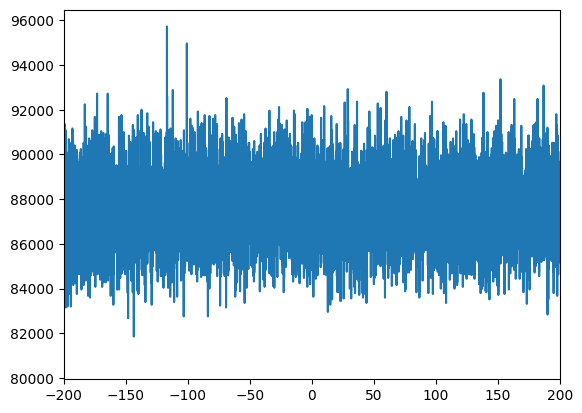

In [59]:
plt.figure()


snr = (rate-np.mean(rate))/rate_err/summary_scale['excvar']

plt.step(
    rel_s_scale,
    rate
)
plt.xlim(-200,200)
            

In [45]:
for e in all_excesses:
    if np.abs(e['scale'] - 0.05)< 0.001:
        # if np.abs(e['excess']['rel_s_scale']) < 5:
        print(e['excess']['rel_s_scale'], e)

-226.63756037363783 {'scale': 0.05000000000000001, 'offset': 0, 'excess': {'snr': 3.449975514903453, 'rel_s_scale': -226.63756037363783, 'rate': 93159.99999999999, 'rate_err': 1364.9908424601242, 'rate_overbkg': 5550.333333333343, 'FAP': 26.43794305757899}}
-173.08752817916684 {'scale': 0.05000000000000001, 'offset': 0, 'excess': {'snr': 3.184008394767713, 'rel_s_scale': -173.08752817916684, 'rate': 92719.99999999999, 'rate_err': 1361.7635624439358, 'rate_overbkg': 5110.333333333343, 'FAP': 42.62535135761764}}
-164.48752280557528 {'scale': 0.05000000000000001, 'offset': 0, 'excess': {'snr': 3.184008394767713, 'rel_s_scale': -164.48752280557528, 'rate': 92719.99999999999, 'rate_err': 1361.7635624439358, 'rate_overbkg': 5110.333333333343, 'FAP': 40.507473457441684}}
-116.68749777018093 {'scale': 0.05000000000000001, 'offset': 0, 'excess': {'snr': 4.973350250442357, 'rel_s_scale': -116.68749777018093, 'rate': 95719.99999999999, 'rate_err': 1383.618444514238, 'rate_overbkg': 8110.333333333

In [21]:
grouped_excesses = []

for i in sorted(all_excesses, key=lambda x:x['excess']['FAP']):
    if i['excess']['FAP']<1 or True:
        print(i['scale'],i['offset'], i['excess']['snr'], i['excess']['rel_s_scale'], i['excess']['FAP'])
        
        grouped=False
        for g in grouped_excesses:
            if abs(i['excess']['rel_s_scale']-g['excess']['rel_s_scale'])<max(i['scale'],g['scale']):
                print("to group", g['excess']['rel_s_scale'])
                if i['excess']['snr'] > g['excess']['snr']:
                    print("group takeover")
                    g.update(i)
                grouped=True
                
        if not grouped:
            print("new group")
            #i['group']=[i]
            grouped_excesses.append(i)
        
    

3.5500000000000007 18 3.5431600096080413 -27.53744603693813 0.05050523236371693
new group
3.500000000000001 24 3.53945843965673 -27.562446051826036 0.05165406673148697
to group -27.53744603693813
3.1000000000000005 26 3.5358176301627053 -27.46244604134136 0.05853352285347965
to group -27.53744603693813
3.5500000000000007 24 3.45312831468794 -27.23744585790383 0.06025253666821205
to group -27.53744603693813
3.750000000000001 10 3.427900638301387 -27.637446055887267 0.061161578281736566
to group -27.53744603693813
3.5500000000000007 16 3.4447716716701695 -27.637446096616234 0.06225781983944263
to group -27.53744603693813
3.3000000000000007 8 3.4503575127019683 -27.362445955408145 0.06550694372302095
to group -27.53744603693813
3.500000000000001 30 3.4137749621410047 -27.262445887401036 0.06670297548209202
to group -27.53744603693813
3.750000000000001 12 3.382638990615746 -27.53744600736536 0.06747129024817519
to group -27.53744603693813
3.1000000000000005 28 3.4598339858482365 -27.362446

In [22]:
grouped_excesses=sorted(grouped_excesses, key=lambda x:x['excess']['FAP'])

for i in grouped_excesses:
    print("%4.2lg"%i['scale'], "%5.2lg"%i['excess']['snr'], "%6.3lg"%i['excess']['rel_s_scale'], "%7.5lg"%i['excess']['FAP'])

 0.3     3   1.64 0.11749
 1.2   3.1   8.01 0.12347
 0.2   4.3  -27.1 0.33033
 0.8   4.3    213 0.61846
 0.1   3.4   10.1 0.92562
 2.1   3.2    128 0.94553
 0.3   3.3  -28.9 0.98953
 0.1     3  -5.06  1.1138
 0.2   3.3  -25.9  1.3786
0.05     5   -117  1.8136
0.05   4.5   -101  2.0892
 0.1   3.1   15.7  2.6235
0.45   3.4   -152  2.9044
 0.2   3.4  -77.9  3.2293
 0.1   3.4   53.3  4.6425
0.05   3.3   29.1  5.0539
 0.2   3.3   95.5  5.7481
 0.2   3.4    179  7.3834
0.25   3.4   -199  7.6308
0.05   3.2   60.4  12.918
0.15   3.2   -140  12.934
0.05   3.6    152  13.032
 0.1   3.6   -227  13.342
0.15   3.1    150  16.997
0.15   3.2   -183  17.855
0.05   3.6    265  19.072
0.15   3.2   -214  20.154
0.05   3.3   -112   20.86
 0.1   3.4   -247  21.637
0.05   3.1  -68.7  24.148
0.05   3.4    187   24.85
0.05   3.5    276  25.092
 0.1   3.1   -137  26.242
0.05   3.2    139  31.805
 0.1   3.1    163  34.295
0.05   3.1   -117  35.514
0.05   3.2   -164  40.507
0.05   3.3    238  41.416
0.05   3.2  

In [23]:
import json

len(json.dumps(grouped_excesses))

10026

In [24]:
summary['ACS']['best']

{'localfar_s': 2.882260100784239,
 'scale': 0.05000000000000001,
 'summary_scale': {'scale_s': 0.05000000000000001,
  'meanrate': 87609.66666666664,
  'maxrate': 95719.99999999999,
  'stdvar': 1560.1427142697198,
  'meanerr': 1323.7043980184294,
  'excvar': 1.1786186678878123,
  'maxsnr': 4.973350250442357,
  'maxsnr_t': -116.68749777018093,
  'localfar': 0.00394833663792898,
  'localfar_s': 2.882260100784239,
  'excesses': [{'snr': 3.449975514903453,
    'rel_s_scale': -226.63756037363783,
    'rate': 93159.99999999999,
    'rate_err': 1364.9908424601242,
    'rate_overbkg': 5550.333333333343,
    'FAP': 26.43794305757899},
   {'snr': 3.184008394767713,
    'rel_s_scale': -173.08752817916684,
    'rate': 92719.99999999999,
    'rate_err': 1361.7635624439358,
    'rate_overbkg': 5110.333333333343,
    'FAP': 42.62535135761764},
   {'snr': 3.184008394767713,
    'rel_s_scale': -164.48752280557528,
    'rate': 92719.99999999999,
    'rate_err': 1361.7635624439358,
    'rate_overbkg': 511

In [25]:
summary['ACS']['s_8']

{0: {'scale_s': 8.000000000000002,
  'meanrate': 87609.66666666666,
  'maxrate': 87937.74999999999,
  'stdvar': 138.01377698943278,
  'meanerr': 104.6480211630078,
  'excvar': 1.318837904965751,
  'maxsnr': 2.372739535631037,
  'maxsnr_t': 159.9876585679158,
  'localfar': 0.66212663140853,
  'localfar_s': 0.4369789260737074,
  'excesses': []},
 'best': {'localfar_s': 1.4584024234461697,
  'scale': 8.0,
  'summary_scale': {'scale_s': 8.000000000000002,
   'meanrate': 87606.92567567567,
   'maxrate': 88004.24999999999,
   'stdvar': 137.3998190312263,
   'meanerr': 104.64638412032905,
   'excvar': 1.312991559013021,
   'maxsnr': 2.885203098178583,
   'maxsnr_t': 210.38768660189817,
   'localfar': 0.1447296530789302,
   'localfar_s': 1.4584024234461697,
   'excesses': []}},
 4: {'scale_s': 8.000000000000002,
  'meanrate': 87607.0304054054,
  'maxrate': 87929.99999999999,
  'stdvar': 139.5603812138867,
  'meanerr': 104.64644667008847,
  'excvar': 1.333637076602027,
  'maxsnr': 2.30993859078

In [26]:
excvar_summary=dict(
)

for k,s in summary['ACS'].items():
    if 'scale_s' in s:
        print("%.5lg"%s['scale_s'], "%5.4lg"%s['excvar'])
        
        if s['scale_s']<=0.200:
            kg='hf_200ms'
        elif s['scale_s']<=2.00:
            kg='mf_200ms_2s'
        elif s['scale_s']<=10.00:
            kg='mf_2s_10s'
        else:
            kg='lf_10s'
        
        if kg not in excvar_summary:
            excvar_summary[kg]=[s['excvar']]
        else:
            excvar_summary[kg]+=[s['excvar']]

for k,v in excvar_summary.items():
    print(k,min(v),max(v))

0.05 1.179
0.1 1.171
0.15 1.182
0.2 1.198
0.25 1.191
0.3   1.2
0.35 1.185
0.4 1.193
0.45 1.224
0.5 1.219
0.55  1.21
0.6 1.218
0.65 1.251
0.7 1.222
0.75 1.236
0.8 1.212
0.85 1.243
0.9 1.246
0.95 1.245
1 1.236
1.1 1.265
1.15 1.231
1.25 1.256
1.3 1.284
1.4 1.222
1.5 1.278
1.6 1.283
1.7 1.252
1.85 1.251
1.95 1.296
2 1.267
2.1 1.242
2.25 1.305
2.4 1.287
2.5 1.232
2.55 1.314
2.7 1.295
2.9 1.286
3 1.383
3.1 1.278
3.3 1.342
3.5 1.345
3.55 1.313
3.75 1.347
4 1.344
4.3 1.279
4.5 1.318
4.6 1.395
4.9 1.408
5 1.358
5.2 1.402
5.5 1.357
5.55 1.383
5.95 1.455
6 1.297
6.35 1.362
6.5 1.309
6.75 1.286
7 1.403
7.2 1.198
7.5 1.188
7.7 1.368
8 1.313
8.2 1.246
8.5 1.315
8.75 1.313
9 1.266
9.35 1.297
9.5 1.267
10 1.403
10.5 1.274
10.65 1.335
11 1.367
11.35 1.229
11.5 1.324
12 1.338
12.1  1.27
12.5 1.439
12.95  1.37
13  1.32
13.5 1.245
13.8 1.323
14 1.279
14.5 1.331
14.7  1.33
15 1.346
15.5 1.332
15.7  1.36
16 1.226
16.5 1.285
16.75 1.251
17 1.284
17.5 1.318
17.85 1.265
18 1.236
18.5 1.412
19  1.36
19.05 1.287

total lc (12000, 4)
min -0.003472078666163725
max 0.003471790929324925
total lc (12000, 4)
min -0.003472078666163725
max 0.003471790929324925
total lc (12000, 4)
min -0.003472078666163725
max 0.003471790929324925
{'scale': 0.30000000000000004, 'offset': 0, 'excess': {'snr': 3.0430007844926252, 'rel_s_scale': 1.6375705628888682, 'rate': 89593.33333333331, 'rate_err': 546.4837092214592, 'rate_overbkg': 1983.666666666657, 'FAP': 0.11749291853875848}}
(-2.0, 2.0)
{'scale': 1.1500000000000001, 'offset': 8, 'excess': {'snr': 3.116652181081367, 'rel_s_scale': 8.012574280703278, 'rate': 88674.78260869565, 'rate_err': 277.6841850308675, 'rate_overbkg': 1065.3058499541075, 'FAP': 0.12346625377569918}}
(-2.0, 2.0)
{'scale': 0.20000000000000004, 'offset': 1, 'excess': {'snr': 4.280955546951909, 'rel_s_scale': -27.0624464872526, 'rate': 91069.99999999999, 'rate_err': 674.7962655498322, 'rate_overbkg': 3460.1833944648242, 'FAP': 0.33033387221996013}}
good match 0.30000000000000004 0.2000000000000000

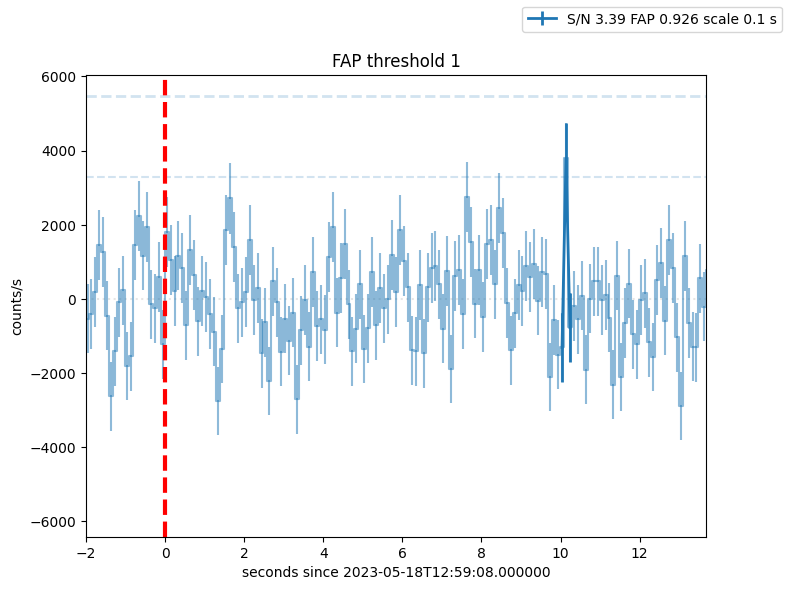

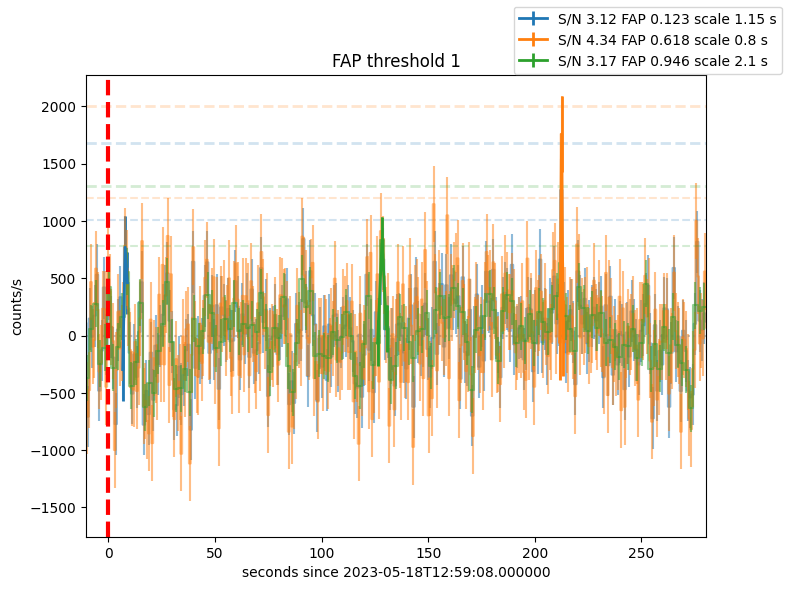

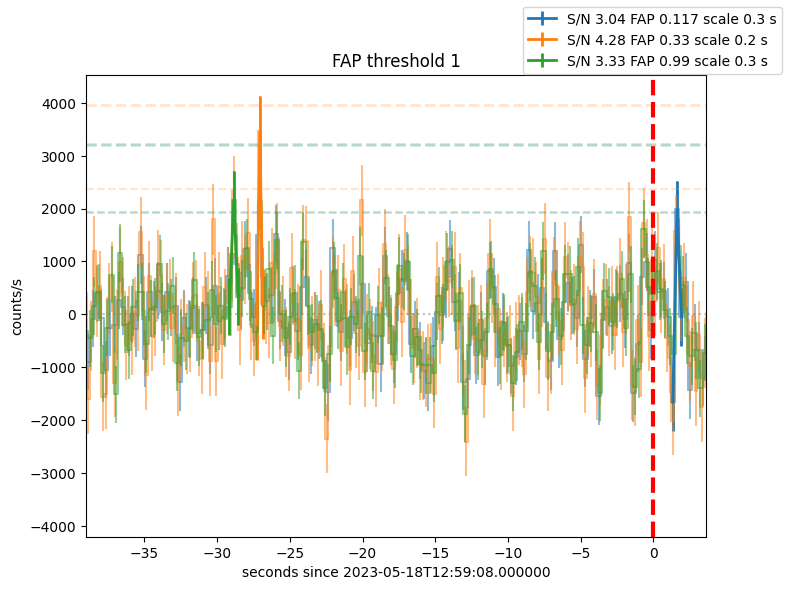

In [27]:
fig_names=[]


for limit_group in 0.02, 0.1, 1: 
    figs=dict()

    for n, lc in lcs.items():
        rel_s = (lc[:,0]-t0_ijd)*24*3600

        m = rel_s>-tstart_rel_mseconds
        m &= rel_s<tstop_rel_seconds

        print("total lc",lc.shape)
        print("min",lc[:,0].min()-t0_ijd)
        print("max",lc[:,0].max()-t0_ijd)

        lc = lc[m]
        rel_s = rel_s[m]

        for excess in grouped_excesses:
            #if excess['excess']['FAP'] > 0.02: continue
            if excess['excess']['FAP'] > limit_group: continue

            print(excess)


            offset = excess['offset']
            nscale = int(excess['scale']/b_tb)  
            scale=excess['scale']

            s_figs = sorted(figs.items(), key=lambda x:abs(x[0]-scale))

            if len(s_figs) == 0 or s_figs[0][0] < scale*0.5 or s_figs[0][0] > scale*1.5: 
                fig = pylab.figure(figsize=(8,6))
                figs[scale] = fig
                pylab.xlim([-2,2])
                pylab.xlabel("seconds since "+t0_utc)
                pylab.ylabel("counts/s")
                pylab.title("FAP threshold %.5lg"%limit_group)
            else:            
                print("good match", s_figs[0][0], scale)
                pylab.figure(s_figs[0][1].number)
                pylab.xlabel("seconds since "+t0_utc)
                pylab.ylabel("counts/s")



            rel_s_scale = rebin(rel_s[offset:],nscale,True)
            rate = rebin(lc[offset:,2],nscale,False)/scale        
            rate_err = rebin(lc[offset:,2],nscale,False)**0.5/scale

            bkg=np.mean(rate)

            m_on = np.abs(rel_s_scale-excess['excess']['rel_s_scale'])<excess['scale']*1.5


            pylab.grid(False)

            pylab.axhline(0, alpha=0.2, ls=":", color='gray')

            cr=pylab.errorbar(
                    rel_s_scale, 
                    (rate-bkg), 
                    (rate_err),
                    alpha=0.5,
                    ls="",
                )[0].get_color()

            pylab.step(
                    rel_s_scale, 
                    (rate-bkg), 
              #      (rate_err),
                    alpha=0.5,
                    where="mid",
                    c=cr,
                )

            pylab.axhline(np.std(rate)*3, alpha=0.2, ls="--",c=cr)
            pylab.axhline(np.std(rate)*5, alpha=0.2, ls="--", lw=2,c=cr)






            pylab.errorbar(
                    rel_s_scale[m_on], 
                    (rate-bkg)[m_on], 
                    (rate_err)[m_on],
                    lw=2.,
                    alpha=1,
                    label="S/N %.3lg FAP %.3lg scale %.3lg s"%(excess['excess']['snr'],excess['excess']['FAP'],excess['scale']),
                    c=cr
                )



            newlim=([
                min([excess['excess']['rel_s_scale']*1.3-excess['scale']*5,-excess['scale']*5]),
                max([excess['excess']['rel_s_scale']*1.3+excess['scale']*5,excess['scale']*5]),
            ])

            oldlim=pylab.gca().get_xlim()

            print(oldlim)

            pylab.xlim([
                min([oldlim[0],newlim[0]]),
                max([oldlim[1],newlim[1]]),
            ])


    for f_i,(s,f) in enumerate(figs.items()):
        f.legend()
        f.gca().axvline(0,ls="--",c="r",lw=3)
        fn="excess_%.5lg_%i.png"%(s,len(fig_names))
        f.savefig(fn)
        fig_names.append(fn)






axes [<Axes: > <Axes: > <Axes: >] <class 'numpy.ndarray'>


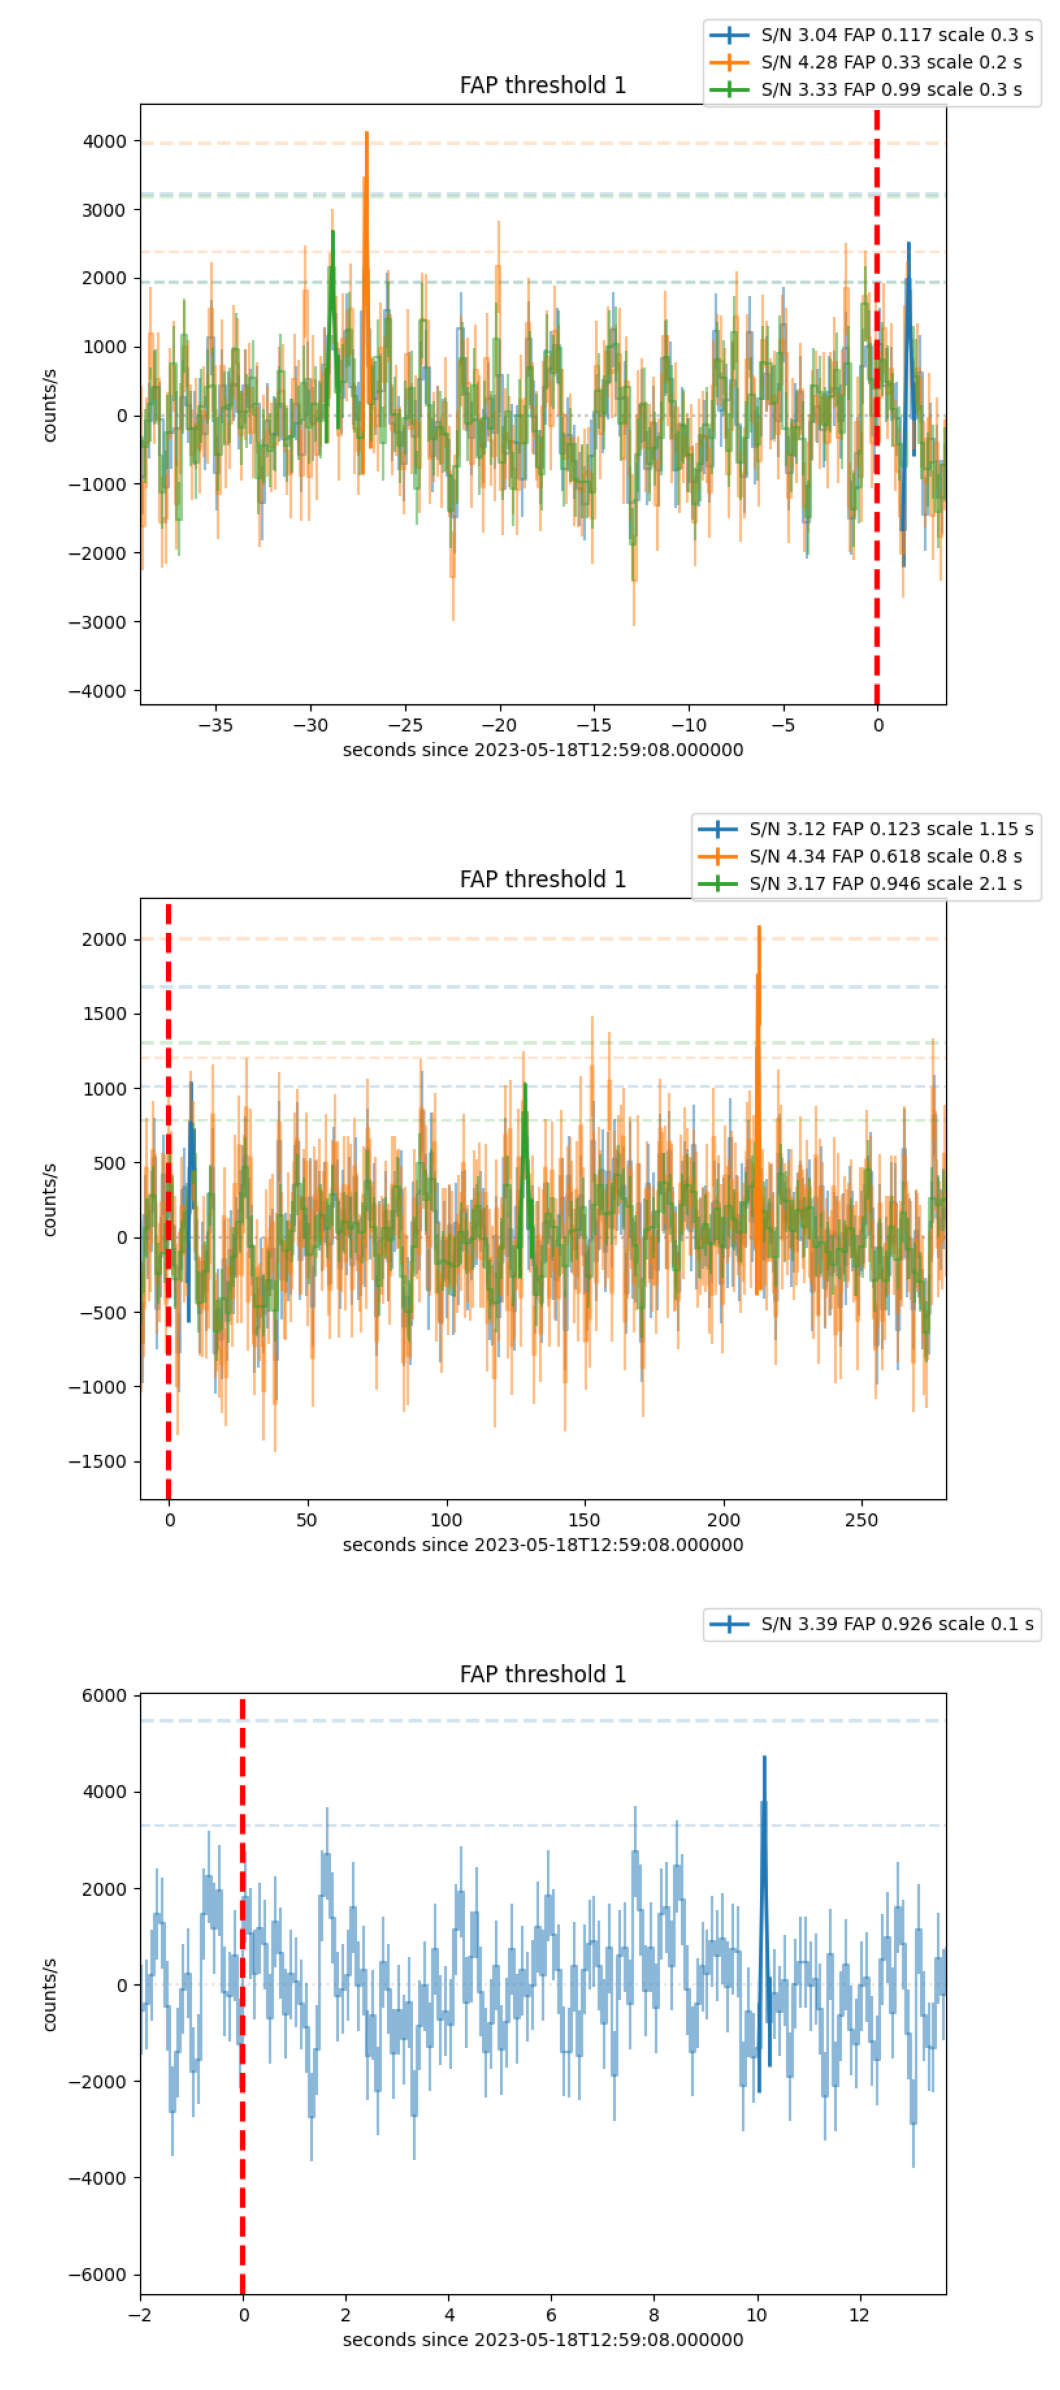

In [28]:
cols=1
rows=int(np.ceil(len(fig_names)/cols))


if rows>0:
    f, axes=pylab.subplots(rows, cols, figsize=(12, 8*rows))
    print("axes",axes,axes.__class__)

    if rows>1:
        axes=axes.flatten()
    else:
        axes=[axes]

    for i,fn in enumerate(fig_names):
        #f.add_subplot(len(fig_names), 2, i+1)
        axes[i].axis('off')
        axes[i].imshow(pylab.imread(fn) ) #, extent=(0,1,0,1))
        #pylab.imshow(pylab.imread(fn), extent=(0,1,(i-1)/len(fig_names),i/len(fig_names)))

    f.tight_layout()
else:
    f=pylab.figure()

f.savefig("excesses_mosaic.png")

In [29]:
if rt == 1:    
    summary['ACS_rt'] = summary['ACS']

In [30]:
summary['ACS']['s_1']['meanerr']

295.98868588222047

In [31]:
import json

json.dump(dict(
    summary=summary,
    reportable_excesses=grouped_excesses,
    excvar_summary=excvar_summary
), open("integral_all_sky.json","w"), indent=4)

In [32]:
acs_lc_png="ACS_lc.png"
acs_rt_lc_png="ACS_lc.png"
acs_rt_det_lc_png="ACS_det_lc.png"
ibis_veto_lc_png="IBIS_Veto_lc.png"
excesses_mosaic_png="excesses_mosaic.png"
summary=summary
reportable_excesses=grouped_excesses
excvar_summary=excvar_summary